In [1]:
from IPython.core.display import display
import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pulp
from itertools import product, combinations_with_replacement
from joblib import Parallel, delayed

In [2]:
np.random.seed(10)
num_places = 10 # number of POI
num_days = 30 # plan days
num_requests = 120 # number of orders

In [3]:
mean_travel_time_to_destinations = 100 # average time for all orders
H_regular = 8*60 # 8 hours / day
H_max_overtime = 3*60 # 3 hours / day
c = 3000 // 60 # cost for over time / min
W = 4000 # 4000kg truck
delivery_outsorcing_unit_cost = 4600 # cost 4600 / 100 kg
delivery_time_window = 3 # window days for order
avg_weight = 1000 # average weight of orders

In [4]:
K = range(num_places) # list of POIs
o = 0 # id for center POI
K_minus_o = K[1:] # id list for destination POIs
_K = np.random.normal(0, mean_travel_time_to_destinations, size=(len(K), 2)) #coordinate of POIs
_K[0, :] = 0 #Coordinate of center POI is 0
t = np.array([[np.floor(np.linalg.norm(_K[k] - K[l]))for k in K] for l in K])
D = range(num_days) # list of days


In [5]:
R = range(num_requests) # list of order
#k[r] = distnation for order r
k = np.random.choice(K_minus_o, size=len(R))
#d_0[r] = start date to deliver order r
d_0 = np.random.choice(D, size=len(R))
#d_1[r] = end date to deliver order r
d_1 = d_0 + delivery_time_window - 1
#w[r] = weight for order r
w = np.floor(np.random.gamma(10, avg_weight/10, size=len(R)))
#f[r] = cost of outsourcing order r
f = np.ceil(w/100)*delivery_outsorcing_unit_cost

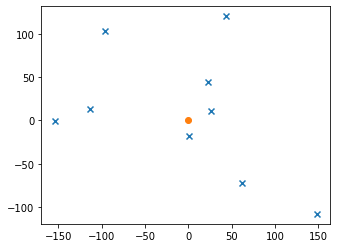

In [6]:
a = plt.subplot()
a.scatter(_K[1:,0], _K[1:,1], marker='x')
a.scatter(_K[0,0], _K[0,1], marker='o')
a.set_aspect('equal')
plt.show()

(array([ 0.,  0.,  0.,  0.,  2.,  9.,  7., 11., 14., 12., 22., 14., 14.,
         9.,  2.,  1.,  2.,  0.,  1.,  0.]),
 array([   0.,  100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,
         900., 1000., 1100., 1200., 1300., 1400., 1500., 1600., 1700.,
        1800., 1900., 2000.]),
 <BarContainer object of 20 artists>)

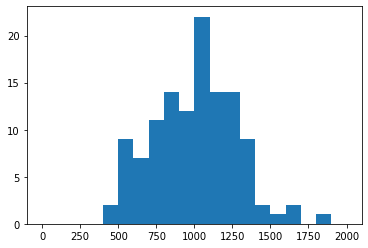

In [7]:
plt.hist(w, bins=20, range=(0,2000))

# 移動経路パターンごとの最適ルート

In [8]:
# create schedules
def simulate_route(z : list):
    # z[k]=1 -> Arrived to POI k
    if z[0] == 0:
        return None # No route don't pass center
    daily_route_prob = pulp.LpProblem(sense=pulp.LpMinimize)

    x = {
        (k, l):pulp.LpVariable(f'x_{k}_{l}a', cat='Binary') 
        if k!=l else pulp.LpAffineExpression() for k, l in product(K, K)
    }

    u = {
        k: pulp.LpVariable(f'u_{k}', lowBound=1, upBound=len(K)-1)
        for k in K_minus_o
    }

    h = pulp.LpVariable('h', lowBound=0, cat='Continuous')

    for l in K:
        daily_route_prob += (
            pulp.lpSum([x[k,l] for k in K]) <= 1
        )
    for l in K:
        if z[l] == 1:
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 1
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 1
            )
        else:
            daily_route_prob += (
                pulp.lpSum([x[k,l] for k in K]) == 0
            )
            daily_route_prob += (
                pulp.lpSum([x[l,k] for k in K]) == 0
            )

    for k,l in product(K_minus_o, K_minus_o): # reduce cycle
        daily_route_prob += (
            u[k] + 1 <= u[l] + len(K_minus_o) * (1-x[k,l])
        )

    travel = pulp.lpSum([t[k,l] * x[k,l] for k, l in product(K,K)])
    daily_route_prob += (travel - H_regular <= h)
    daily_route_prob += (h <= H_max_overtime)

    daily_route_prob += travel
    daily_route_prob.solve()

    return {
        'z':z,
        'route':{(k,l):x[k,l].value() for k,l in product(K,K)},
        'optimal': daily_route_prob.status == 1,
        'moving_time':travel.value(),
        'overtime':h.value()
    }

def enumerate_routes():
    routes = Parallel(n_jobs=16, prefer='threads')(
        [delayed(simulate_route)(z) for z in product([0,1], repeat=len(K))]
    )
    routes = pd.DataFrame(filter(lambda x: x is not None, routes))

    routes = routes[routes.optimal].copy()
    return routes

routes_df = enumerate_routes()

In [9]:
routes_df

,z,route,optimal,moving_time,overtime
1,"(1, 0, 0, 0, 0, 0, 0, 0, 0, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,195.0,0.0
2,"(1, 0, 0, 0, 0, 0, 0, 0, 1, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,125.0,0.0
3,"(1, 0, 0, 0, 0, 0, 0, 0, 1, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,308.0,0.0
4,"(1, 0, 0, 0, 0, 0, 0, 1, 0, 0)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,59.0,0.0
5,"(1, 0, 0, 0, 0, 0, 0, 1, 0, 1)","{(0, 0): 0, (0, 1): 0.0, (0, 2): 0.0, (0, 3): ...",True,230.0,0.0
...,...,...,...,...,...
500,"(1, 1, 1, 1, 1, 1, 0, 1, 0, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,453.0,0.0
501,"(1, 1, 1, 1, 1, 1, 0, 1, 0, 1)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,629.0,149.0
502,"(1, 1, 1, 1, 1, 1, 0, 1, 1, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,565.0,85.0
504,"(1, 1, 1, 1, 1, 1, 1, 0, 0, 0)","{(0, 0): 0, (0, 1): 1.0, (0, 2): 0.0, (0, 3): ...",True,551.0,71.0


## 各日付の移動と配送する荷物を指定したスケジュールの列挙
移動経路上で配送可能な荷物の部分集合のうち、重量制限を守れるものを日毎に列挙

In [10]:
def is_OK(requests):
    weight = sum([w[r] for r in requests])
    if weight > W:
        return False
    
    best_route_idx = None
    best_hours = sys.float_info.max

    for route_idx, row in routes_df.iterrows():
        all_requests_on_route = all([row.z[k[r]] == 1 for r in requests])
        if all_requests_on_route and row.moving_time < best_hours: #relax
            best_route_idx = route_idx
            best_hours = row.moving_time
    
    if best_route_idx is None:
        return False
    else:
        return best_route_idx, best_hours

In [11]:

def _enumerate_feasible_schedules(requests_cands, 
                                    current_idx_set, idx_to_add, res, idx):

    idx_set_to_check = current_idx_set + [idx_to_add]
    next_idx = idx_to_add + 1
    is_next_idx_valid = next_idx < len(requests_cands)
    requests = [requests_cands[i] for i in idx_set_to_check]
    is_ok = is_OK(requests)

    idx = idx+1
    # print(idx, len(idx_set_to_check), next_idx, len(res))

    if is_ok:
        best_route_idx, best_hour = is_ok
        res.append(
            {
                'requests': [requests_cands[i] for i in idx_set_to_check],
                'route_idx': best_route_idx,
                'hours': best_hour
            }
        )

        if is_next_idx_valid:
            _enumerate_feasible_schedules(requests_cands, 
                                            idx_set_to_check, next_idx, res, idx)
    if is_next_idx_valid:
        _enumerate_feasible_schedules(requests_cands, 
                                            current_idx_set, next_idx, res, idx) # skip add idx

In [12]:
def enumerate_feasible_schedule(d: int):
    # list up schedules on day "d"
    requests_cands = [r for r in R if d_0[r] <= d <= d_1[r]]

    res = [
        {
            'requests':[], 'route_idx':0, 'hours':0
        }
    ]

    _enumerate_feasible_schedules(requests_cands, [], 0, res, 0)

    feasible_schedule_df = pd.DataFrame(res)
    feasible_schedule_df['overwork'] = \
        (feasible_schedule_df.hours - H_regular).clip(0)
    feasible_schedule_df['requests_set'] = \
        feasible_schedule_df.requests.apply(set)

    idx_cands = set(feasible_schedule_df.index)
    dominated_idx_set = set()
    for dominate_idx in feasible_schedule_df.index:
        for checked_idx in feasible_schedule_df.index:
            request_strict_dominance = (
                feasible_schedule_df.requests_set.loc[checked_idx] < feasible_schedule_df.requests_set.loc[dominate_idx]
            )
            overwork_weak_dominance = (
                feasible_schedule_df.overwork.loc[checked_idx] >= feasible_schedule_df.overwork.loc[dominate_idx]
            )

            if request_strict_dominance and overwork_weak_dominance:
                dominated_idx_set.add(checked_idx)

    nondominated_idx_set = idx_cands - dominated_idx_set
    nondominated_feasible_schedules_df = feasible_schedule_df.loc[nondominated_idx_set, :]
    return nondominated_feasible_schedules_df

In [13]:
_schedules = Parallel(n_jobs=16, prefer='threads')([delayed(enumerate_feasible_schedule)(d) for d in D])
feasible_schedules = dict(zip(D, _schedules))

In [14]:
'max schedule cands / day', max([len(df) for df in feasible_schedules.values()])

('max schedule cands / day', 1383)

In [15]:
'sum schedule cands', sum([len(df) for df in feasible_schedules.values()])

('sum schedule cands', 11772)

# Solve the problem

In [17]:
prob = pulp.LpProblem(sense=pulp.LpMinimize)

# variables
z = {}
for d in D:
    for q in feasible_schedules[d].index:
        z[d, q] = pulp.LpVariable(f'z_{d}_{q}', cat='Binary')

y = {
    r: pulp.LpVariable(f'y_{r}', cat='Continuous', lowBound=0, upBound=1) for r in R
}

deliv_count = {r: pulp.LpAffineExpression() for r in R}
for d in D:
    for q in feasible_schedules[d].index:
        for r in feasible_schedules[d].loc[q].requests:
            deliv_count[r] += z[d, q]

h = {
    d: pulp.lpSum(
        z[d, q] * feasible_schedules[d].overwork.loc[q]
        for q in feasible_schedules[d].index
    )
    for d in D
}

# Constrains
for d in D:
    prob += (
        pulp.lpSum(z[d, q] for q in feasible_schedules[d].index) == 1
        # one schedule in one day
    )
for r in R:
    prob += (
        y[r] >= 1 - deliv_count[r]
        # outsourcing delivery
    )

# Objectives
obj_overtime = pulp.lpSum([c * h[d] for d in D])
obj_outsorcing = pulp.lpSum([f[r] * y[r] for r in R])

obj_total = obj_overtime + obj_outsorcing
prob += obj_total

prob.solve()

1

# Result

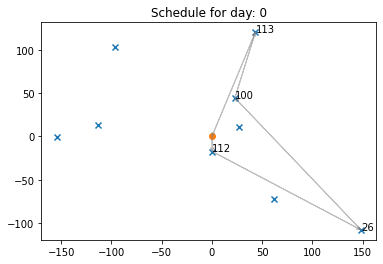

In [20]:
# visualize by day
def visualize_route(d):
    for q in feasible_schedules[d].index:
        if z[d, q].value() > 0.5:
            route_summary = feasible_schedules[d].loc[q]
            route_geography = routes_df.loc[route_summary.route_idx]
            break
    
    a = plt.subplot()
    a.scatter(_K[1:,0], _K[1:,1], marker='x')
    a.scatter(_K[0,0], _K[0, 1], marker='o')

    motions = [(k_from, k_to) for (k_from, k_to), used 
                in route_geography.route.items() if used > 0]

    for k_from, k_to in motions:
        p_from = _K[int(k_from)]
        p_to = _K[int(k_to)]
        a.arrow(
            *p_from, *(p_to-p_from),
            head_width=3,
            length_includes_head=True,
            overhang=0.5,
            color='gray',
            alpha=0.5
        )
        requests_at_k_to = [r for r in route_summary.requests if k[r]==k_to]
        a.text(*p_to, ''.join([str(r) for r in requests_at_k_to]))
    plt.title(f'Schedule for day: {d}')
    plt.show()

visualize_route(0)

In [21]:
requests_summary_df = pd.DataFrame(
    [{
        'outsourced': y[r].value(),
        'weight': w[r],
        'freight': f[r],
        'location': k[r],
        'distance_from_o': t[k[r], o]
    } for r in R]
)

In [22]:
requests_summary_df.groupby('outsourced')[['weight', 'freight', 'distance_from_o']].agg('mean')

,weight,freight,distance_from_o
outsourced,,,
0.0,994.920354,47872.566372,6.265487
1.0,1219.857143,57171.428571,6.285714


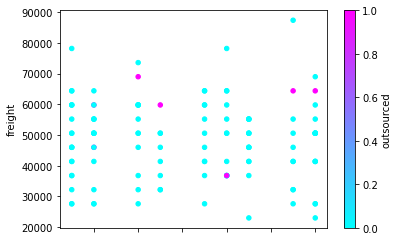

In [23]:
requests_summary_df.plot.scatter(x='distance_from_o', y='freight', c='outsourced', cmap='cool')
plt.show()